# Krill Growth Potential (KGP) Data Processing from CESM2-LE
- Process data for Southern Ocean total KGP in growing season
- Notebook by Zephyr Sylvester (CU Boulder), Alice DuVivier (NCAR), Kristen Krumhardt (NCAR)
- Note: this notebook needs to load the utils.py file
- December 2023

## Steps for calculating KGP

$KGP = length + CHL_{sfc} + SST$

We calculate Antarctic krill (Euphausia superba) growth potential using an empirical relationship derived from surface quantities. The method follows Atkinson et al. 2006 (https://www.doi.org/10.4319/lo.2006.51.2.0973). Specific equations for each step are provided in the "Calculate your metric" section.

1) Calculate total surface chlorophyll from all phytoplankton types

2) Calculate individual terms
- length term
- chlorophyll term
- SST term

3) Sum all terms to get KGP


In [1]:
import utils
import xarray as xr
import numpy as np
import dask
from distributed import Client
from dask.distributed import wait
from ncar_jobqueue import NCARCluster
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Spin up DASK cluster

In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='2:00:00', cores=1, processes=1, memory='100 GB', 
                      resource_spec='select=1:ncpus=1:mem=100GB',interface='ext')

# Spin up 32 workers
cluster.scale(32)

# Assign the cluster to our Client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.105:44475,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Define some functions we'll need to load data

In [4]:
# define the metrics we can load 
metrics_dict = {
    "NPP": ['photoC_TOT_zint'],
    "Zooplankton Production": ['graze_diat_zint', 'graze_sp_zint'],
    "Diatom fraction (biomass)": ['diatC', 'spC'],
    "Mesozoo production": ['graze_diat_zint', 'graze_sp_zint', 'diatC', 'spC'],
    "Mesozooplankton biomass": ['zooC', 'diatC', 'spC', 'graze_diat_zint', 'graze_sp_zint'],
    "Trophic Level 3": ['graze_diat_zint', 'graze_sp_zint', 'diatC', 'spC'],
    "Krill Growth Potential": ['TEMP','diatChl','spChl','diazChl']
}

def get_metrics_list():
    return list(metrics_dict.keys())

In [5]:
# function to return the variables we need to return for all metrics
def get_metric_variable(metric):
    var_names = metrics_dict[metric]
    # handle the case where there is only one variable
    if isinstance(var_names, str):
        return var_names
    # handle the case where there are multiple variables
    else:
        return var_names[:]

In [6]:
# function to average over top 150m for relevant variables and to keep time bound
def preprocess(ds):
    tb = ds.time_bound
    # check if relevant variables are in dataset, and if so, average over the dimension
    if hasattr(ds,'TEMP'):
        print('getting top level (500cm) temperature')
        temp = ds.TEMP
        ds['TEMP'] = temp.isel(z_t=0)
        ds['TEMP'].attrs['long_name'] = 'ocean temperature, surface (500cm)'
        del(temp)    
    if hasattr(ds,'diatChl'):
        print('getting top level (500cm) diatom chlorophyll')
        temp = ds.diatChl
        ds['diatChl'] = temp.isel(z_t_150m=0)
        ds['diatChl'].attrs['long_name'] = 'diatom chlorophyll, surface (500cm)'
        del(temp) 
    if hasattr(ds,'diazChl'):
        print('getting top level (500cm) diazatroph chlorophyll')
        temp = ds.diazChl
        ds['diazChl'] = temp.isel(z_t_150m=0)
        ds['diazChl'].attrs['long_name'] = 'diazatroph chlorophyll, surface (500cm)'
        del(temp)         
    if hasattr(ds,'spChl'):
        print('getting top level (500cm) small phytoplankton chlorophyll')
        temp = ds.spChl
        ds['spChl'] = temp.isel(z_t_150m=0)
        ds['spChl'].attrs['long_name'] = 'small phytoplankton chlorophyll, surface (500cm)'
        del(temp)         
    if hasattr(ds,'diatC'):
        print('averaging diatC over top 150m')
        temp = ds.diatC
        ds['diatC'] = temp.mean(dim='z_t_150m')
        ds['diatC'].attrs['long_name'] = 'diatom plankton carbon, top 150m mean'
        del(temp)
    if hasattr(ds,'spC'):
        print('averaging spC over top 150m')
        temp = ds.spC
        ds['spC'] = temp.mean(dim='z_t_150m')
        ds['spC'].attrs['long_name'] = 'small phytoplankton carbon, top 150m mean'
        del(temp)
    
    #re-write time bound with saved value
    ds['time_bound'] = tb
    return ds

In [7]:
# function for loading datasets
def load_datasets(varnames, experiment,lat_min,lat_max):
    ds_list = []
    for varname in varnames:
        subset = catalog.search(component='ocn',
                                variable=varname,
                                experiment=experiment,
                                forcing_variant='cmip6',
                               )
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            dsets = subset.to_dataset_dict()
        ds = dsets[f'ocn.{experiment}.pop.h.cmip6.{varname}'] 
        
        # compute time mean to get correct months
        ds['time']= ds.time_bound.compute().mean(dim="d2")
        # keep only some variables
        keep_vars=['z_t','time_bound','z_t_150m','KMT','TLAT','TLONG','time'] + [varname]
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        ds_list.append(ds)
        ds = xr.merge(ds_list, compat="override")
        
        # crop data to the latitudes we want, use given lat/lon, not specific indices
        #ds = ds.isel(nlat=slice(0,37)) # Crop to Southern Ocean, ind_start = 0, ind_end = 37
        ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)
        
    return ds

## Select the metric you are interested in

In [8]:
import utils

In [9]:
## Print out potential metrics to investigate:
metrics_list = get_metrics_list()
print(metrics_list)

['NPP', 'Zooplankton Production', 'Diatom fraction (biomass)', 'Mesozoo production', 'Mesozooplankton biomass', 'Trophic Level 3', 'Krill Growth Potential']


In [10]:
## Enter the metric  of interest:
metric = 'Krill Growth Potential'

In [11]:
## Enter the years you want to keep:
yy_st = "1950"
yy_ed = "2100"

In [12]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

## Load CESM2-LE data

In [13]:
# for the metric supplied, define the list of required variable names
varnames = get_metric_variable(metric) 
varnames

['TEMP', 'diatChl', 'spChl', 'diazChl']

### Load the Data Catalog

In [14]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

### Load historical data

In [15]:
%%time
# load historical
ds_hist = load_datasets(varnames,'historical',lat_min,lat_max)
# preprocess if some variables need depth averaging
ds_hist = preprocess(ds_hist)
ds_hist


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


getting top level (500cm) temperature
getting top level (500cm) diatom chlorophyll
getting top level (500cm) diazatroph chlorophyll
getting top level (500cm) small phytoplankton chlorophyll
CPU times: user 1min 46s, sys: 2.51 s, total: 1min 49s
Wall time: 3min 14s


<xarray.Dataset>
Dimensions:     (nlat: 36, nlon: 320, time: 1980, d2: 2, member_id: 50, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time        (time) object 1850-01-16 13:00:00.000001 ... 2014-12-16 12:00:00
Dimensions without coordinates: nlat, nlon, d2, member_id
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    TEMP        (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
    diatChl     (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
    spChl       (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
    diazChl     (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    NCO:                     netCDF Operators version 4.9.5 (Homepage = http:...
    calendar:                All years have exactly  365 days.
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source:                  CCSM POP2, the CCSM Ocean Component
    revision:                $Id$
    cell_methods:            cell_methods = time: mean ==> the variable value...
    intake_esm_varname:      ['TEMP']
    contents:                Diagnostic and Prognostic Variables
    history:                 none\nnone\nThu Dec  9 19:03:25 2021: ncks -O -F...
    time_period_freq:        month_1
    Conventions:             CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf...
    intake_esm_dataset_key:  ocn.historical.pop.h.cmip6.TEMP

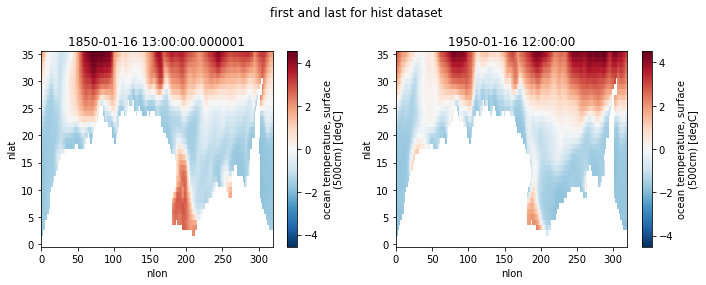

In [16]:
mem_5_hist = ds_hist.TEMP.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_hist.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_hist.isel(time=0).time.values)

mem_5_hist.isel(time=1200).plot(ax=ax2)
ax2.set_title(mem_5_hist.isel(time=1200).time.values)

fig.suptitle("first and last for hist dataset")

plt.tight_layout()
plt.show()

### Load future data

In [17]:
%%time
# load historical
ds_ssp = load_datasets(varnames,'ssp370',lat_min,lat_max)
# preprocess if some variables need depth averaging
ds_ssp = preprocess(ds_ssp)
ds_ssp


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


getting top level (500cm) temperature
getting top level (500cm) diatom chlorophyll
getting top level (500cm) diazatroph chlorophyll
getting top level (500cm) small phytoplankton chlorophyll
CPU times: user 48.7 s, sys: 847 ms, total: 49.5 s
Wall time: 1min 17s


<xarray.Dataset>
Dimensions:     (nlat: 36, nlon: 320, time: 1032, d2: 2, member_id: 50, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time        (time) object 2015-01-16 13:00:00.000001 ... 2100-12-16 12:00:00
Dimensions without coordinates: nlat, nlon, d2, member_id
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    TEMP        (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
    diatChl     (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
    spChl       (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
    diazChl     (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    calendar:                All years have exactly  365 days.
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source:                  CCSM POP2, the CCSM Ocean Component
    revision:                $Id$
    cell_methods:            cell_methods = time: mean ==> the variable value...
    intake_esm_varname:      ['TEMP']
    contents:                Diagnostic and Prognostic Variables
    history:                 none
    time_period_freq:        month_1
    Conventions:             CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf...
    intake_esm_dataset_key:  ocn.ssp370.pop.h.cmip6.TEMP

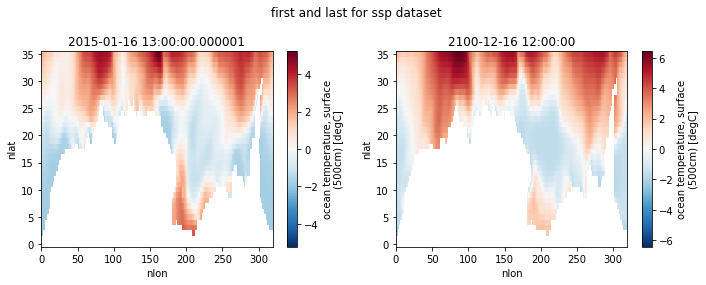

In [18]:
mem_5_ssp = ds_ssp.TEMP.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ssp.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_ssp.isel(time=0).time.values)

mem_5_ssp.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5_ssp.isel(time=-1).time.values)

fig.suptitle("first and last for ssp dataset")

plt.tight_layout()
plt.show()

## Concatenate historical and future datasets, keep just years of interest

In [19]:
ds = xr.concat((ds_hist, ds_ssp),dim='time')
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 13, 0, 0, 1, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 13:00:00.000001 ... 2100-12-16 12:00:00

In [20]:
# keep just years chosen above
ds = ds.sel(time=slice(yy_st, yy_ed))
#ds = ds.isel(time=slice(1200, 3012)) # Cut timeseries to 1950 - 2100: 1812 time steps
ds.time

<xarray.DataArray 'time' (time: 1812)>
array([cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00

## Compute your metric!

### Calculate Surface Chlorophyll

```ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl)```

In [21]:
%%time
# Compute Surface Chl
ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).persist()
wait(ds['Chl_surf'])
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

CPU times: user 49.5 s, sys: 2.16 s, total: 51.7 s
Wall time: 6min 11s


### Calculate Individual terms

In [22]:
%%time

# specify constant parameters (from Atkinson et. al 2006)
a = -0.066
b = 0.002
c = -0.000061
d = 0.385
e = 0.328
f = 0.0078
g = -0.0101

# specify the krill length in mm (use 40 as default)
length = 40.

# compute terms and sum
length_term = (a + (b * length) + (c * length**2))
chl_term = (d * (ds.Chl_surf / (e + ds.Chl_surf)))
sst_term = ((f * ds.TEMP) + (g * ds.TEMP**2))

CPU times: user 17.4 ms, sys: 43 µs, total: 17.5 ms
Wall time: 19.9 ms


### Calculate KGP

In [23]:
varname = 'KGP'

In [24]:
%%time
# Compute KGP
# sum terms
kgp = length_term + chl_term + sst_term
# mask based on SST range
kgp = kgp.where((-1. <= ds.TEMP) & (ds.TEMP <= 5.)).fillna(0.).where(ds.KMT > 0).compute()

CPU times: user 35.9 s, sys: 8.56 s, total: 44.5 s
Wall time: 7min 41s


In [25]:
# add this to the dataset
ds[varname] = kgp
ds[varname].attrs['long_name'] = 'Krill daily growth rate'
ds[varname].attrs['units'] = 'mm/day'

# Compute Seasonal Integrals
* Growing season = ONDJFM 
* Early Season = OND
* Late Season = JFM


In [26]:
#starting with Jan, list of days in each month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [27]:
# Dataset will become shorter because of the Jan.1 boundary for some seasons
# for 1950-2100, 150 years long (1800 time steps instead of 1812). Last year will be 2099
years = np.arange(int(yy_st),int(yy_ed),1)

tlen = 150 #annual timesteps 
xlen = len(ds.nlon)
ylen = len(ds.nlat)
elen = len(ds.member_id)
print(tlen,xlen,ylen,elen)

150 320 36 50


In [29]:
# set data metric for calculations
data_metric = ds[varname]

### Compute Growing Season (ONDJFM)

In [33]:
%%time

ds_Oct_Mar_int = xr.Dataset()

Oct_Mar_int = np.zeros([tlen,elen,ylen,xlen])

for year in np.arange(0,tlen,1):

    #get october for this year
    st_mon = year*12 + 9

    #sum over oct to following year march
    i=0
    for month in [10,11,12,1,2,3]:

        if(month == 10):
            summing = data_metric.isel(time=st_mon) * days_per_month[month-1]
        else:
            summing = summing + data_metric.isel(time=st_mon+i) * days_per_month[month-1]

        i = i + 1

    Oct_Mar_int[year,:,:,:] = summing

# convert to xarray
Oct_Mar_int = xr.DataArray(Oct_Mar_int,dims=('time','member_id','nlat','nlon'))

ds_Oct_Mar_int[varname] = Oct_Mar_int
ds_Oct_Mar_int[varname].attrs['units'] = 'mol/m2/year'
ds_Oct_Mar_int['time'] = years
ds_Oct_Mar_int

CPU times: user 1.7 s, sys: 119 ms, total: 1.82 s
Wall time: 2.8 s


<xarray.Dataset>
Dimensions:  (time: 150, member_id: 50, nlat: 36, nlon: 320)
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP      (time, member_id, nlat, nlon) float64 nan nan nan ... 4.782 4.768

### Compute Early Season (OND)

In [34]:
%%time
ds_OND_int = xr.Dataset()

OND_int = np.zeros([tlen,elen,ylen,xlen])

for year in np.arange(0,tlen,1):

    #get october for this year
    st_mon = year*12 + 9

    #sum over oct to december
    i=0
    for month in [10,11,12]:

        if(month == 10):
            summing = data_metric.isel(time=st_mon) * days_per_month[month-1]
        else:
            summing = summing + data_metric.isel(time=st_mon+i) * days_per_month[month-1]

        i = i + 1

    OND_int[year,:,:,:] = summing

# convert to xarray
OND_int = xr.DataArray(OND_int,dims=('time','member_id','nlat','nlon'))

ds_OND_int[varname] = OND_int
ds_OND_int[varname].attrs['units'] = 'mol/m2/year'
ds_OND_int['time'] = years
ds_OND_int

CPU times: user 783 ms, sys: 167 ms, total: 950 ms
Wall time: 1.23 s


<xarray.Dataset>
Dimensions:  (time: 150, member_id: 50, nlat: 36, nlon: 320)
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP      (time, member_id, nlat, nlon) float64 nan nan nan ... 10.05 9.866

### Compute Late Season (JFM)

In [35]:
%%time
ds_JFM_int = xr.Dataset()

JFM_int = np.zeros([tlen,elen,ylen,xlen])

for year in np.arange(0,tlen,1):

    #get january for this year
    st_mon = year*12 + 0

    #sum over january through march
    i=0
    for month in [1,2,3]:

        if(month == 1):
            summing = data_metric.isel(time=st_mon) * days_per_month[month-1]
        else:
            summing = summing + data_metric.isel(time=st_mon+i) * days_per_month[month-1]

        i = i + 1

    JFM_int[year,:,:,:] = summing

# convert to xarray
JFM_int = xr.DataArray(JFM_int,dims=('time','member_id','nlat','nlon'))

ds_JFM_int[varname] = JFM_int
ds_JFM_int[varname].attrs['units'] = 'mol/m2/year'
ds_JFM_int['time'] = years
ds_JFM_int

CPU times: user 841 ms, sys: 121 ms, total: 962 ms
Wall time: 1.02 s


<xarray.Dataset>
Dimensions:  (time: 150, member_id: 50, nlat: 36, nlon: 320)
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP      (time, member_id, nlat, nlon) float64 nan nan nan ... -7.648 -7.232

## Put together into one dataset

- Netcdf with variable dimension: (member_id x year x nlat x nlon)
- Include TAREA, andd TLAT and TLONG as coordinates
- One netcdf per variable per time period: ONDJFM (whole growing season), OND (early), JFM (late)

In [36]:
# load grid data to include in output file
dir_in = '/glade/u/home/duvivier/masks/'
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon

# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [38]:
ds_out = xr.Dataset()

ds_out['KGP_ONDJFM'] = ds_Oct_Mar_int[varname]
ds_out['KGP_ONDJFM'].attrs['units'] = 'mm/year'
ds_out['KGP_ONDJFM'].attrs['long_name'] = 'Krill growth potential over the whole growing season (ONDJFM)'
ds_out['KGP_OND'] = ds_OND_int[varname]
ds_out['KGP_OND'].attrs['units'] = 'mm/year'
ds_out['KGP_OND'].attrs['long_name'] = 'Krill growth potential over the early growing season (OND)'
ds_out['KGP_JFM'] = ds_JFM_int[varname]
ds_out['KGP_JFM'].attrs['units'] = 'mm/year'
ds_out['KGP_JFM'].attrs['long_name'] = 'Krill growth potential over the late growing season (JFM)'
ds_out['TAREA'] = ds_grid.TAREA

# add global attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'yearly {varname} in the Southern Ocean from 1950 to 2099 from the CESM2 Large Ensemble.'

ds_out

<xarray.Dataset>
Dimensions:     (nlat: 36, nlon: 320, time: 150, member_id: 50)
Coordinates:
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time        (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Dimensions without coordinates: member_id
Data variables:
    KGP_ONDJFM  (time, member_id, nlat, nlon) float64 nan nan ... 4.782 4.768
    KGP_OND     (time, member_id, nlat, nlon) float64 nan nan ... 10.05 9.866
    KGP_JFM     (time, member_id, nlat, nlon) float64 nan nan ... -7.648 -7.232
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-06-19
    contents:        yearly KGP in the Southern Ocean from 1950 to 2099 from ...

In [39]:
# drop the ULAT/ULONG variables
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')

In [40]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	nlat: (36,)
	nlon: (320,)
	time: (150,)
	member_id: (50,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 

## Export and Save

In [41]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 1.93 GB.


In [44]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'
file_out = 'CESM2-LE-seasonal-integrals-'+varname+'.nc'
fout = path_out + file_out

In [45]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [46]:
cluster.close()

## Test if it worked

In [47]:
path =  path_out
ds_test =  xr.open_dataset(path_out+file_out, decode_times=True)

In [48]:
ds_test.info()

xarray.Dataset {
dimensions:
	nlat = 36 ;
	nlon = 320 ;
	time = 150 ;
	member_id = 50 ;

variables:
	int64 nlat(nlat) ;
	int64 nlon(nlon) ;
	int64 time(time) ;
	float64 KGP_ONDJFM(time, member_id, nlat, nlon) ;
		KGP_ONDJFM:units = mm/year ;
		KGP_ONDJFM:long_name = Krill growth potential over the whole growing season (ONDJFM) ;
	float64 KGP_OND(time, member_id, nlat, nlon) ;
		KGP_OND:units = mm/year ;
		KGP_OND:long_name = Krill growth potential over the early growing season (OND) ;
	float64 KGP_JFM(time, member_id, nlat, nlon) ;
		KGP_JFM:units = mm/year ;
		KGP_JFM:long_name = Krill growth potential over the late growing season (JFM) ;
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float64 TAREA(nlat, nlon) ;
		TAREA:long_name = area of T cells ;
		TAREA:units = centimeter^2 ;

// global attributes:
	:author = Alice

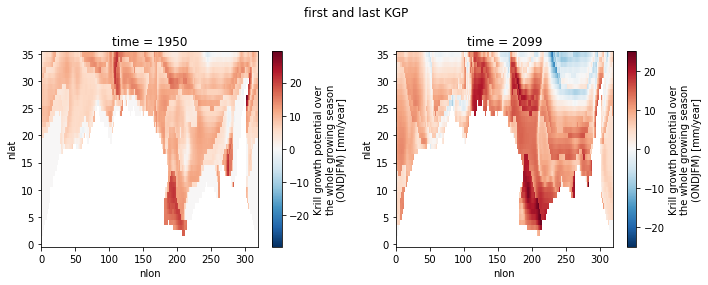

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [50]:
mem_5_ints = ds_test.KGP_ONDJFM.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ints.isel(time=0).plot(ax=ax1)
# ax1.set_title(mem_5_ints.isel(time=0).time.values)

mem_5_ints.isel(time=-1).plot(ax=ax2)
#ax2.set_title(mem_5_ints.isel(time=-1).time.values)

fig.suptitle("first and last KGP")

plt.tight_layout()
plt.show()